In [160]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, cohen_kappa_score
)
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

In [161]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

METRICS = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score, pos_label=1),  # Classe 1 é 'B'
    "precision": make_scorer(precision_score, pos_label=1),
    "f1": make_scorer(f1_score, pos_label=1),
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "specificity": make_scorer(specificity_score),
    "kappa": make_scorer(cohen_kappa_score),
}


In [162]:
data_path = "C:/Users/afili/Desktop/Uni/Mestrado/AASE/apartments_for_rent_10k_final.csv" 
data = pd.read_csv(data_path, sep=';')

In [163]:
# Codificar as colunas categóricas
le = LabelEncoder()
data["cityname_transformed"] = le.fit_transform(data["cityname_transformed"])
data["pets_allowed_transformed"] = le.fit_transform(data["pets_allowed_transformed"])
data["has_photo_transformed"] = le.fit_transform(data["has_photo_transformed"])
data["price_class"] = le.fit_transform(data["price_class"])

In [165]:
# 2. Definir as colunas que deseja verificar por outliers
numerical_features = ['price', 'square_feet', 'bathrooms', 'bedrooms']

# 3. Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrar dados dentro dos limites
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 4. Aplicar a função para remover outliers
data_cleaned = remove_outliers(data, numerical_features)

# 5. Verificar o tamanho do dataset após remoção
print(f"Tamanho original do dataset: {data.shape}")
print(f"Tamanho após remoção de outliers: {data_cleaned.shape}")

Tamanho original do dataset: (9994, 53)
Tamanho após remoção de outliers: (8546, 53)


In [166]:
features = [
    'bathrooms', 'bedrooms', 'pets_allowed_transformed', 'cityname_transformed',
    'has_photo_transformed', 'square_feet', 'AC', 'Alarm', 'Basketball',
    'Cable or Satellite', 'Clubhouse', 'Dishwasher', 'Doorman', 'Elevator',
    'Fireplace', 'Garbage Disposal', 'Gated', 'Golf', 'Gym', 'Hot Tub',
    'Internet Access', 'Luxury', 'Parking', 'Patio/Deck', 'Playground',
    'Pool', 'Refrigerator', 'Storage', 'TV', 'Tennis', 'View', 'Washer Dryer',
    'Wood Floors'
]

X = data_cleaned[features]
X = pd.get_dummies(X, drop_first=True)
y = data_cleaned['price_class']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [168]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [170]:
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=55,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=1234
)
scores_dt = cross_validate(dt, X_train, y_train, cv=10, scoring=METRICS)

In [171]:
nn = MLPClassifier(
    hidden_layer_sizes=(100,), 
    activation='tanh', 
    solver='adam', 
    alpha=0.0001, 
    learning_rate='constant', 
    max_iter=200, 
    random_state=1234
)
scores_nn = cross_validate(nn, X_train, y_train, cv=10, scoring=METRICS)

In [172]:
rf = RandomForestClassifier(
    criterion='gini',
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=50,
    random_state=1234
)
scores_rf = cross_validate(rf, X_train, y_train, cv=10, scoring=METRICS)

In [173]:
models_scores = {
    "Decision Tree": scores_dt,
    "Neural Network": scores_nn,
    "Random Forest": scores_rf,
}

In [174]:
for model_name, scores in models_scores.items():
    print(f"\nResultados para {model_name}:")
    for metric, values in scores.items():
        if metric.startswith("test"):
            print(f"{metric}: {np.mean(values):.4f}")


Resultados para Decision Tree:
test_accuracy: 0.6343
test_recall: 0.6762
test_precision: 0.6817
test_f1: 0.6786
test_auc: 0.6606
test_specificity: 0.5783
test_kappa: 0.2542

Resultados para Neural Network:
test_accuracy: 0.6542
test_recall: 0.7845
test_precision: 0.6712
test_f1: 0.7198
test_auc: 0.6972
test_specificity: 0.4804
test_kappa: 0.2725

Resultados para Random Forest:
test_accuracy: 0.6947
test_recall: 0.8114
test_precision: 0.7014
test_f1: 0.7523
test_auc: 0.7539
test_specificity: 0.5391
test_kappa: 0.3599


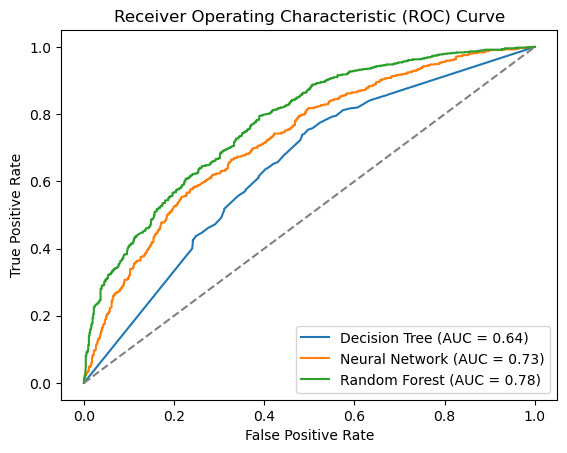

In [175]:
dt.fit(X_train, y_train)
y_pred_dt = dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt, pos_label=1)  # Ajuste o 'pos_label' conforme necessário
auc_dt = roc_auc_score(y_test, y_pred_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')

# Neural Network
nn.fit(X_train, y_train)
y_pred_nn = nn.predict_proba(X_test)[:, 1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn, pos_label=1)
auc_nn = roc_auc_score(y_test, y_pred_nn)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.2f})')

# Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf, pos_label=1)
auc_rf = roc_auc_score(y_test, y_pred_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# Configuração do gráfico
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha base
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Modelo base
rf = RandomForestClassifier(random_state=1234)

# Espaço de busca otimizado
param_grid = {
    'n_estimators': [50, 100, 150, 200],       # Número de árvores na floresta (reduzido para diminuir o tempo)
    'max_depth': [10, 20, 30, 40],            # Profundidade máxima das árvores
    'min_samples_split': [2, 5],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2],        # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2'],         # Apenas o mais comum para reduzir combinações
    'criterion': ['gini']             # Reduzido para o melhor desempenho observado anteriormente
}

# Configurar o GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',  # Pode ajustar para 'f1' ou 'roc_auc'
    cv=10,                # Validação cruzada
    n_jobs=-1            # Utilizar todos os processadores disponíveis
)

# Treinar o modelo com os dados de treino
grid_search_rf.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros para Random Forest:", grid_search_rf.best_params_)
print("Melhor score para Random Forest:", grid_search_rf.best_score_)

# Melhor modelo com os hiperparâmetros ajustados
best_rf = grid_search_rf.best_estimator_

# Avaliar no conjunto de teste
from sklearn.metrics import classification_report

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))


Melhores hiperparâmetros para Random Forest: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Melhor score para Random Forest: 0.6947021653694999
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       733
           1       0.71      0.83      0.76       977

    accuracy                           0.71      1710
   macro avg       0.71      0.69      0.69      1710
weighted avg       0.71      0.71      0.70      1710



In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Modelo base
dt = DecisionTreeClassifier(random_state=1234)

# Espaço de busca expandido
param_grid = {
    'max_depth': [45, 50, 55],  # Faixa ampla baseada nos resultados anteriores
    'min_samples_split': [2, 5, 10],   # Testar divisões maiores
    'min_samples_leaf': [1, 2, 4],     # Reduzir folhas menores
    'criterion': ['gini', 'entropy']   # Explorar ambos os critérios
}

# Configurar o GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',  # Pode usar outra métrica como 'f1' ou 'roc_auc'
    cv=10,  # Validação cruzada
    n_jobs=-1  # Utilizar todos os núcleos disponíveis
)

# Treinar o modelo com os dados de treino
grid_search_dt.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros para Decision Tree:", grid_search_dt.best_params_)
print("Melhor score para Decision Tree:", grid_search_dt.best_score_)

# Melhor modelo com os hiperparâmetros ajustados
best_dt = grid_search_dt.best_estimator_

# Avaliar no conjunto de teste
from sklearn.metrics import classification_report

y_pred = best_dt.predict(X_test)
print(classification_report(y_test, y_pred))


Melhores hiperparâmetros para Decision Tree: {'criterion': 'entropy', 'max_depth': 55, 'min_samples_leaf': 1, 'min_samples_split': 10}
Melhor score para Decision Tree: 0.6342815922187117
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       733
           1       0.67      0.68      0.68       977

    accuracy                           0.63      1710
   macro avg       0.62      0.62      0.62      1710
weighted avg       0.63      0.63      0.63      1710



In [152]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Modelo base
mlp = MLPClassifier(random_state=1234, max_iter=200)

# Espaço de busca reduzido
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Camadas ocultas simplificadas
    'activation': ['relu', 'tanh'],  # Apenas ReLU e tanh, mais comuns
    'solver': ['adam'],  # Apenas Adam, que é rápido e eficaz
    'alpha': [0.0001, 0.001],  # Regularização L2 com poucos valores
    'learning_rate': ['constant']  # Apenas constante para simplicidade
}

# Configurar o GridSearchCV
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',  # Pode mudar para 'f1' ou 'roc_auc'
    cv=10,                # Reduz para 3 folds de validação cruzada
    n_jobs=-1            # Utilizar todos os processadores disponíveis
)

# Treinar o modelo com os dados de treino
grid_search_mlp.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros para Neural Network:", grid_search_mlp.best_params_)
print("Melhor score para Neural Network:", grid_search_mlp.best_score_)

# Melhor modelo com os hiperparâmetros ajustados
best_mlp = grid_search_mlp.best_estimator_

# Avaliar no conjunto de teste
from sklearn.metrics import classification_report

y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))


Melhores hiperparâmetros para Neural Network: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Melhor score para Neural Network: 0.6610569554682215
              precision    recall  f1-score   support

           0       0.70      0.40      0.51       733
           1       0.66      0.87      0.75       977

    accuracy                           0.67      1710
   macro avg       0.68      0.64      0.63      1710
weighted avg       0.68      0.67      0.65      1710



In [153]:
X_new = data_cleaned[features] 

X_new = X_new.fillna(0)

#B=1 e A=0

data_cleaned['predicted_price_class'] = best_rf.predict(X_new).astype(int)

data_cleaned['predicted_price_class'] = le_city.inverse_transform(
    data_cleaned['predicted_price_class']
)

output_file_class = 'C:/Users/afili/Desktop/Uni/Mestrado/AASE/predicted_price_class.csv'
data_cleaned[['predicted_price_class']].to_csv(output_file_class, index=False)

print(f"Arquivo salvo com sucesso: {output_file_class}")


Arquivo salvo com sucesso: C:/Users/afili/Desktop/Uni/Mestrado/AASE/predicted_price_class.csv
